# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The player **taking the last object wins**.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

In [1]:
%load_ext autoreload
%autoreload 2

from task1_lib import gabriele, pure_random, fixed_rules_strategy, optimal_strategy
from task2_lib import run_GA, strategy_0, strategy_1, strategy_2
from task3_lib import task_3_run
from task4_lib import task4_Q, task4_Q_optimal
from nim_utils import evaluate, evaluate_GA, play_match

# Task 1

In [2]:
NUM_MATCHES = 100
NIM_SIZE = 10
K_SIZE = None

print(f"Win-rate against {gabriele.__name__}: {evaluate(fixed_rules_strategy, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against {pure_random.__name__}: {evaluate(fixed_rules_strategy, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")


Win-rate against gabriele: 1.0
Win-rate against pure_random: 0.94


# Task 2

In [6]:
# Strategy 0
print(f"**********************  Strategy 0  **********************")
genome_parameters = ["alpha", "beta", "gamma"]
num_generations = 150
best_genome = run_GA(genome_parameters, strategy_0, num_generations)

print(f"Win-rate against gabriele: {evaluate_GA(best_genome, strategy_0, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against pure_random: {evaluate_GA(best_genome, strategy_0, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")


# Strategy 1
print(f"**********************  Strategy 1  **********************")
genome_parameters = ["alpha", "beta"]
num_generations = 30
best_genome = run_GA(genome_parameters, strategy_1, num_generations)

print(f"Win-rate against gabriele: {evaluate_GA(best_genome, strategy_1, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against pure_random: {evaluate_GA(best_genome, strategy_1, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")


# Strategy 2
print(f"**********************  Strategy 2  **********************")
genome_parameters = ["alpha", "beta", "gamma", "percentage"]
num_generations = 30
best_genome = run_GA(genome_parameters, strategy_2, num_generations)

print(f"Win-rate against gabriele: {evaluate_GA(best_genome, strategy_2, gabriele, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")
print(f"Win-rate against pure_random: {evaluate_GA(best_genome, strategy_2, pure_random, NUM_MATCHES, NIM_SIZE, k_size=K_SIZE)}")

**********************  Strategy 0  **********************
[info] - Start generating the population


100%|██████████| 50/50 [00:03<00:00, 16.27it/s]


[info] - Evolving...


100%|██████████| 150/150 [04:00<00:00,  1.60s/it]


[info] - Best genome found is {'alpha': 0.01800586212049826, 'beta': 0.8972145043409917, 'gamma': 0.995560494814241} with fitness: (0.97, 0.53)
Win-rate against gabriele: 0.84
Win-rate against pure_random: 0.51
**********************  Strategy 1  **********************
[info] - Start generating the population


100%|██████████| 50/50 [00:02<00:00, 23.08it/s]


[info] - Evolving...


100%|██████████| 30/30 [00:24<00:00,  1.20it/s]


[info] - Best genome found is {'alpha': 0.4616514831786915, 'beta': 0.047724304547968166} with fitness: (1.0, 0.98)
Win-rate against gabriele: 1.0
Win-rate against pure_random: 0.9
**********************  Strategy 2  **********************
[info] - Start generating the population


100%|██████████| 50/50 [01:10<00:00,  1.41s/it]


[info] - Evolving...


100%|██████████| 30/30 [18:25<00:00, 36.86s/it]


[info] - Best genome found is {'alpha': 0.012349345323732993, 'beta': 0.10731537121275468, 'gamma': 0.8692153589304976, 'percentage': 0.51064632792086} with fitness: 0.99
Win-rate against gabriele: 0.95
Win-rate against pure_random: 0.95


In [ ]:
import random
from nimply import Nim

def challenge(genome0, strategy_0, genome1, strategy_1, num_matches=100, nim_size=10, k_size=None):
    won = 0

    for m in range(num_matches):
        nim = Nim(nim_size, k=k_size)
        player = random.randint(0, 1)
        while nim:
            if player == 0:
                ply = strategy_0(nim, genome0)
            else:
                ply = strategy_1(nim, genome1)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            won += 1
    return won / num_matches

genome0 = {'alpha': 0.33806644070961167, 'beta': 0.8983983212868427, 'gamma': 0.9974669535320325}
genome1 = {'alpha': 0.8191618758747532, 'beta': 0.10484407005864857}

challenge(genome0, strategy_0, genome1, strategy_1)

# Task 3

In [3]:
opponent_strategy = pure_random
#opponent_strategy = optimal_strategy
is_opponent_starting = True

task_3_run(pure_random, is_opponent_starting)

INFO:root:status: Minmax won!


--- 0.03383183479309082 seconds ---


# Task 4

100%|██████████| 5000/5000 [00:13<00:00, 365.11it/s]

max winrate:  (96.0, 2700)


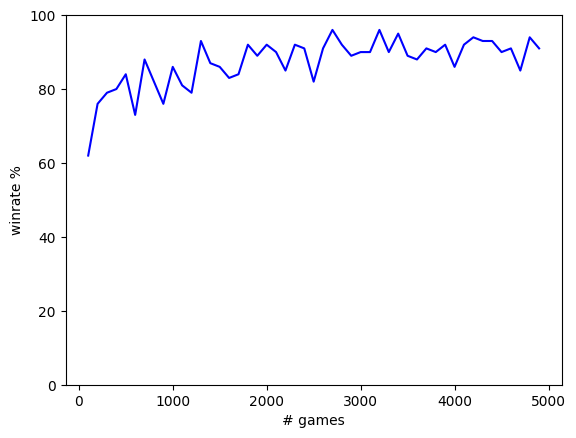

In [4]:
# alpha = 0.3, gamma = 0.9, epsilon = 0.1 -> (max_winrate, iteration) = (96.0, 4300)

info = {
    'alpha': 0.3,  # learning rate
    'gamma': 0.9,  # memory
    'epsilon': 0.1 # chance of making a random move
}

task4_Q(info)

100%|██████████| 30000/30000 [02:03<00:00, 242.18it/s]


max winrate:  (85.0, 8000)


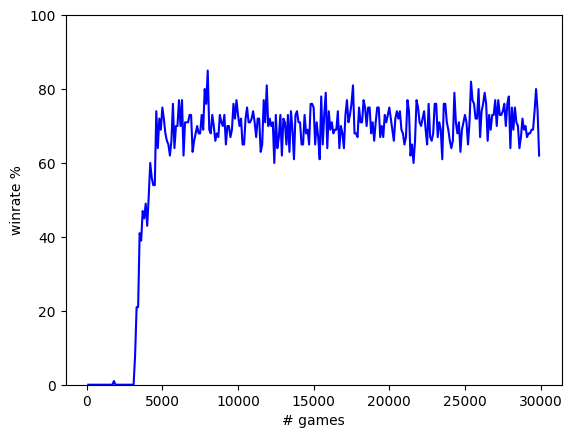

In [6]:
info = {
    'alpha': 0.3,  # learning rate
    'gamma': 0.9,  # memory
    'epsilon': 0.1 # chance of making a random move
}

task4_Q_optimal(info, iterations=30000)